# Project Implementation: C2ST - Logisitic Regression classifier
## CPSC 532S
### By James Riddell

This project implements a simple C2ST model with Logistic Regression. Runs on two samples from specified Distributions, P and Q, to predict whether P=Q. 


# Setting up the environment

The overall goal of this project is to find whether P=Q for the two $S_p \sim P, S_q \sim Q$. Labels all points from $S_p$ with lable = 0, and all points from $S_q$ with lable = 1. The theory is that if the samples are produced from distinct distributes then a binary classifier should be able to learn a seperator between them that preforms much better than chance.

To do this we define 2 distributions P and Q and draw samples with size n from each. 

After this the samples are treated as inputs to the model which accomlishes the following:
-  Assigns appropriate labels to each training point in the sets (according to which sample they belong to)
-  Defines $D = \{S_p, 0\}\cup\{S_q, 1\}$ and shuffles the 2n examples
-  Splits data into $D_{tr}$ and $D_{te}$
-  Trains a logistic regression classifier on $D_{tr}$ with logistic loss and SGD/Adam
-  Tests the classifier on $D_{te}$ to determine $\hat{t}$ based on the percentage of examples classified correctly

In [23]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.distributions as distributions

# import plotting utilities
import matplotlib.pyplot as plt
from IPython import display

# define constants
import math # needed for math.pi
alpha = 0.05
n = 100

device = "cuda"

In [39]:
# 2 simple distributions for testing

#one dimensional tests
#d=1
#P = distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.5]))
#Q = distributions.normal.Normal(torch.tensor([0.8]), torch.tensor([0.3]))
#Q = distributions.poisson.Poisson(torch.tensor([4.0]))
#Q = distributions.studentT.StudentT(4.0, torch.tensor([0.1]))

#two dimensional tests
#d=2
#P = distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
#Q = distributions.multivariate_normal.MultivariateNormal(0.5*torch.ones(2), torch.eye(2))
#P = distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), 0.3 * torch.eye(2))
#Q = distributions.multivariate_normal.MultivariateNormal(0.5*torch.ones(2), 0.5 *torch.eye(2))


#high dimensional tests 
d=30
P = distributions.multivariate_normal.MultivariateNormal(torch.linspace(-2.1,2,d), 0.3 * torch.eye(d))
Q = distributions.multivariate_normal.MultivariateNormal(0.5*torch.ones(d) - torch.linspace(-2,2,d), 0.5 *torch.eye(d))

Q=P
sample_shape = torch.Size([n])
# draw two samples from the distributions
S_p = P.sample(sample_shape)
#print(S_p[0].shape)
S_q = Q.sample(sample_shape)

print(sample_shape)
print(S_q.shape)
print(S_p.shape)

torch.Size([100])
torch.Size([100, 30])
torch.Size([100, 30])


# Data loader initialization given two samples $S_p$ and $S_q$

In [40]:
# attach corresponding labels to S_p and S_q
S_p_labeled = {'examples' : S_p, 'labels' : torch.zeros((n,))}
S_q_labeled = {'examples' : S_q, 'labels' : torch.ones((n,))}

#print(S_p_labeled['labels'].shape)
#print(S_p_labeled['labels'].shape)
#print(torch.cat([S_p_labeled['labels'], S_q_labeled['labels']], 0))

In [41]:
# create combined dataset

class CombinedSamplesDataSet(torch.utils.data.Dataset):
    def __init__(self):
        super(CombinedSamplesDataSet).__init__();
        print("Loading dataset to memory, can take some seconds for large n")
        self.examples = torch.vstack([S_p_labeled['examples'], S_q_labeled['examples']])
        self.labels = torch.cat([S_p_labeled['labels'], S_q_labeled['labels']], 0)
        r_indices = torch.randperm(len(self.examples))
        self.examples = self.examples[r_indices]
        self.labels = self.labels[r_indices]
        print(".. done loading")
        
        print(self.examples.shape)
        print(self.labels.shape)
        
    def __len__(self):
        return self.examples.shape[0]
    
    def __getitem__(self, idx):
        sample = {'example': self.examples[idx],
                  'label': self.labels[idx]}
        return sample

In [42]:
# split the dataset into training and test (inference) subsets
D = CombinedSamplesDataSet()
print("Number of examples in dataset: {}".format(len(D)))

val_ratio = 0.2
val_size = int(len(D)*val_ratio)
indices_val = list(range(0, val_size))
indices_train = list(range(val_size, len(D)))

D_te = torch.utils.data.Subset(D, indices_val)
D_tr = torch.utils.data.Subset(D, indices_train)

print("Number of examples in D_te: {}".format(len(D_te)))
print("Number of examples in D_tr: {}".format(len(D_tr)))

Loading dataset to memory, can take some seconds for large n
.. done loading
torch.Size([200, 30])
torch.Size([200])
Number of examples in dataset: 200
Number of examples in D_te: 40
Number of examples in D_tr: 160


In [43]:
# display dataset examples on top of the underlying distributions (sanity)
x = torch.linspace(-2, 2, n**2)
const = torch.zeros((n,))
y_p = torch.exp(P.log_prob(x))
y_q = torch.exp(Q.log_prob(x))
plt.plot(x, y_p, color='r', label='P')
plt.scatter(S_p, const, s=1, color='r', label='S_p')
plt.plot(x, y_q, color='g', label='Q')
plt.scatter(S_q, const, s=1, color='g', label='S_q')
plt.legend()
plt.show()



ValueError: ignored

In [44]:
# a helper function to map between devices (GPU and CPU)
def dict_to_device(dict_in, device):
    dict_out = {}
    for k,v in dict_in.items():
        dict_out[k] = v.to(device)
    return dict_out

# C2ST training

Implementaion of a Logistic Regression Classifier and training loops using logisitic loss. Note that Binary Cross Entropy loss minimizes the same thing as logistic loss here.

In [45]:
# model architecture

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)
    def forward(self, x):
        outputs = self.linear(x['example'])
        return outputs

model = LogisticRegressionModel(d).cuda()

In [46]:
# main training loop
def train(train_loader, network, loss_fn, num_training_epochs, key="label"):
    losses = []
    
    optimizer = optim.Adam(network.parameters(), lr=0.01)
    for epoch in range(num_training_epochs):
        iterator = iter(train_loader)
        network.train()
        for i in range(len(train_loader)):
            batch_cpu = next(iterator)
            batch_size = batch_cpu[key].shape[0]

            batch = dict_to_device(batch_cpu, device)

            preds = network(batch)
            #print(preds)
            logit_preds = torch.sigmoid(preds)
            loss = loss_fn(torch.squeeze(logit_preds), batch[key])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if epoch % max(num_training_epochs//1000, 2) == 0:
            plt.cla()
            plt.plot(losses, label='loss')
            #plt.yscale('log')
            plt.title('Training loss')
            plt.xlabel('number of gradient iterations')
            plt.legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Epoch {}, iteration {} of {} ({} %), loss={}".format(epoch, i, len(train_loader), 100*i//len(train_loader), losses[-1]))
    display.clear_output(wait=True)
plt.close('all')

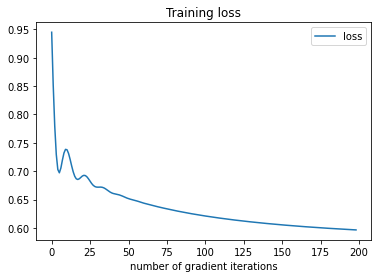

In [47]:
train_loader = torch.utils.data.DataLoader(D_tr, batch_size = len(D_tr), shuffle=True)
loss_fn = nn.BCELoss() # loss function
train(train_loader, model, loss_fn, num_training_epochs=200)

In [21]:
# confirm the model implementation with sklearn logistic regression

import numpy as np
from sklearn.linear_model import LogisticRegression

# X, y = [], []
# for item in D_tr:
#   X.append(item['example'].detach().numpy())
#   y.append(item['label'].detach().numpy())
# X = np.stack(X)
# y = np.stack(X).astype('int')

# Xv, yv = [], []
# for item in D_te:
#   Xv.append(item['example'].detach().numpy())
#   yv.append(item['label'].detach().numpy())
# Xv = np.stack(Xv)
# yv = np.stack(Xv).astype('int')

# model2 = LogisticRegression()
# model2.fit(X, y)

# preds = model2.predict(Xv)

# from collections import Counter
# Counter(preds)

# Generating $\hat{t}$ : Predictions on Test set

To generate the learned t statistic, we evaluate a sample probablity that our predicts the labels correctly (corresponding to $1 - \sum_{i=1}^{n_{te}} L_{D_{te}}^{0-1} (\\{f(z_i) > \frac{1}{2}\}, l_i)$, where the model predicts 0 if it is more likely that the example is a member sampled from P and 1 if it is more likely to have come from p.



In [48]:
# evaluation loop
def eval(test_loader, network, loss_fn, key="label"):
    losses = 0
    iterator = iter(test_loader)
    network.eval()
    for i in range(len(test_loader)):
        batch_cpu = next(iterator)
        batch_size = batch_cpu[key].shape[0]

        batch = dict_to_device(batch_cpu, device)
        preds = network(batch)
        #print(preds)
        loss = loss_fn(torch.squeeze(preds), batch[key])
        losses += loss.item()
    print("losses: ", losses)
    print("n_te: ", len(D_te))
    return losses/len(D_te)

# Custom Loss funciton
class TStatisticLoss(nn.Module):
    def __init__(self):
        super(TStatisticLoss, self).__init__()
        self.__name__ = "TStatisticLoss"

    def forward(self, inputs, targets):
        outputs = (inputs >= 0.5) == targets
        return sum(outputs)


In [49]:
test_loader = torch.utils.data.DataLoader(D_te, shuffle=True, drop_last=False)
loss_fn = TStatisticLoss() # loss function
t_hat = eval(test_loader, model, loss_fn)
print("t_hat", t_hat)

losses:  20
n_te:  40
t_hat 0.5


# Inference: Can we reject the Null Hypothesis?

In [50]:
T_H0 = distributions.normal.Normal(.5, (1 / (4 * len(D_te))))
p_hat = (1 - T_H0.cdf(torch.tensor([t_hat]))).item()
print("p_hat: ", p_hat)

if (p_hat < alpha):
    print("Reject the Null Hypothesis, P != Q")
else:
    print("Accept the Null Hypothesis, P = Q")

p_hat:  0.5
Accept the Null Hypothesis, P = Q


# Plotting the hyperplane boundry

In [ ]:
param_array = []
for param in model.parameters():
    print(param)
    param_array.append(param)
boundary = (param_array[1]/(-param_array[0])).detach().cpu().item()#-0.5735/-2.4561
print(boundary)

Parameter containing:
tensor([[-0.5260]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0023], device='cuda:0', requires_grad=True)
-0.004457530099898577


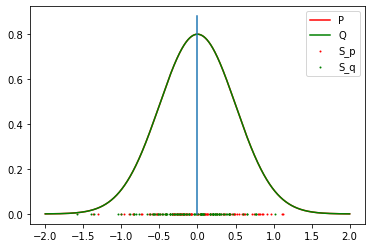

In [ ]:
x = torch.linspace(-2, 2, n**2)
const = torch.zeros((n,))
y_p = torch.exp(P.log_prob(x))
y_q = torch.exp(Q.log_prob(x))
plt.plot(x, y_p, color='r', label='P')
plt.scatter(S_p, const, s=1, color='r', label='S_p')
plt.plot(x, y_q, color='g', label='Q')
plt.scatter(S_q, const, s=1, color='g', label='S_q')
plt.legend()

#Plot the boundary
height_p = max(y_p) 
height_q = max(y_q)
height = max([height_p, height_q])*1.1
plt.plot([boundary, boundary], [0, height])

plt.show()